# Grammatical Error Correction (GEC)

Ten notebook pokazuje krok po kroku, jak:
1. Załadować i przygotować dane (np. ConLL‐2014, JFLEG lub inny korpus GEC).
2. Skomponować model seq2seq (np. T5‐Base lub BART) do zadania korekty błędów.
3. Nałożyć na bazowy model adapter LoRA lub uprościć fine‐tuning.
4. Trenować model na danych GEC.
5. Dokonać ewaluacji (metryka F<sub>0.5</sub> lub BLEU na prostym zestawie walidacyjnym).
6. Przetestować przykładowe zdania.

#### Instalacja niezbędnych bibliotek

In [1]:
!pip install transformers datasets sacrebleu sentencepiece
!pip install peft

In [2]:
import os
import numpy as np
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    pipeline
)
import sacrebleu
import torch
import matplotlib.pyplot as plt
# (opcjonalnie) użycie LoRA:
from peft import LoraConfig, get_peft_model, PeftModel

device = 0 if torch.cuda.is_available() else -1
print("Urządzenie do trenowania/inferencji:", "cuda" if device == 0 else "cpu")

/Users/amika/python-global/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Urządzenie do trenowania/inferencji: cpu


In [3]:
raw = load_dataset("jfleg")["validation"]

splits = raw.train_test_split(test_size=0.20, seed=42)

token_source = DatasetDict({
    "train": splits["train"],
    "validation": splits["test"]
})

print(token_source)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 604
    })
    validation: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 151
    })
})


#### Tokenizer i funkcję preprocess

In [4]:
MODEL_BASE = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE)


def preprocess_batch(batch, max_len=128):
    inputs = ["gec: " + s for s in batch["sentence"]]
    targets = [c[0] for c in batch["corrections"]]

    model_inputs = tokenizer(
        inputs,
        max_length=max_len,
        truncation=True,
        padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_len,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


max_len = 128
tokenized_datasets = token_source.map(
    lambda batch: preprocess_batch(batch, max_len=max_len),
    batched=True,
    remove_columns=token_source["train"].column_names
)

print(tokenized_datasets["train"][0].keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


#### Konfiguracja LoRA i modelu seq2seq

In [5]:
lora_r = 8
lora_alpha = 32
lora_dropout = 0.1

lora_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    target_modules=["q", "v"],
    lora_dropout=lora_dropout,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_BASE)
model = get_peft_model(base_model, lora_config)

#### Data collator

In [6]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=-100
)

In [7]:
experiment_name = "t5base_gf_20k_ep3_lora8"
output_dir = os.path.join("results_gec", experiment_name)
os.makedirs(output_dir, exist_ok=True)

#### Funkcja metryk (BLEU)

In [8]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    max_token_id = tokenizer.vocab_size - 1
    preds = np.clip(preds, 0, max_token_id)
    labels = np.clip(labels, 0, max_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    return {"bleu": bleu.score}

In [9]:
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    generation_max_length=max_len,
    generation_num_beams=4,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
    dataloader_pin_memory=False,
)

#### Trening modelu Seq2Seq

In [10]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_3923/500907040.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Bleu
1,No log,10.558151,27.358801
2,No log,8.954256,24.451813
3,10.316400,8.367601,24.270149


That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


TrainOutput(global_step=114, training_loss=10.12998012074253, metrics={'train_runtime': 305.8573, 'train_samples_per_second': 5.924, 'train_steps_per_second': 0.373, 'total_flos': 277089137197056.0, 'train_loss': 10.12998012074253, 'epoch': 3.0})

#### Podsumowanie treningu

In [11]:
best_bleu = trainer.state.best_metric
print(f"Najlepszy BLEU na walidacji: {best_bleu:.2f}")

Najlepszy BLEU na walidacji: 27.36


In [12]:
adapter_dir = os.path.join(output_dir, "lora_adapter")
model.save_pretrained(adapter_dir)
print("Adapter LoRA zapisany w:", adapter_dir)

Adapter LoRA zapisany w: results_gec/t5base_gf_20k_ep3_lora8/lora_adapter


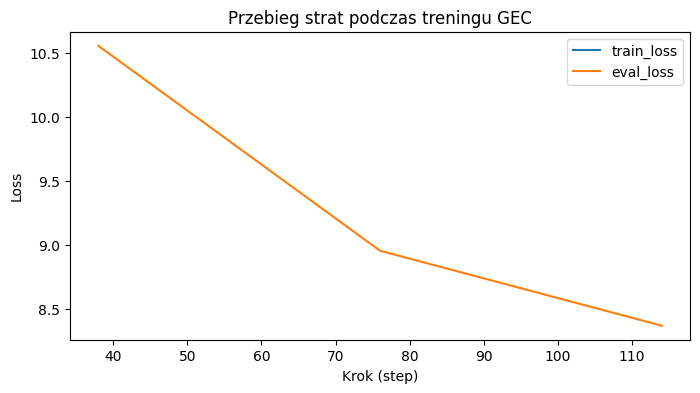

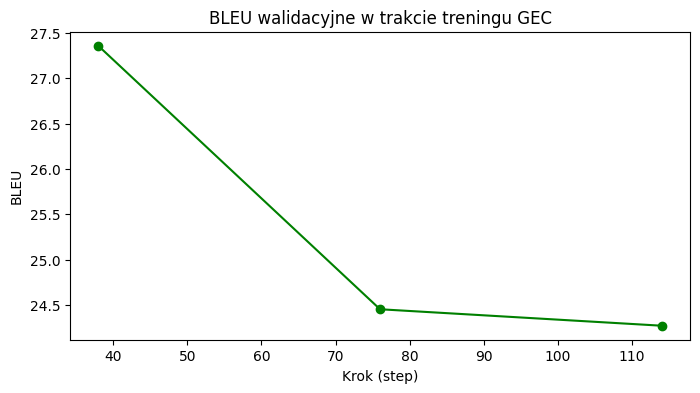

In [13]:
logs = trainer.state.log_history

steps = [entry["step"] for entry in logs if "step" in entry and "loss" in entry]
train_ls = [entry["loss"] for entry in logs if "loss" in entry and "epoch" not in entry.get("key", "")]
eval_ls = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]
eval_steps = [entry["step"] for entry in logs if "eval_loss" in entry]

plt.figure(figsize=(8, 4))
plt.plot(steps, train_ls, label="train_loss")
plt.plot(eval_steps, eval_ls, label="eval_loss")
plt.xlabel("Krok (step)")
plt.ylabel("Loss")
plt.title("Przebieg strat podczas treningu GEC")
plt.legend()
plt.show()

eval_bleu = [entry["eval_bleu"] for entry in logs if "eval_bleu" in entry]
bleu_steps = [entry["step"] for entry in logs if "eval_bleu" in entry]

plt.figure(figsize=(8, 4))
plt.plot(bleu_steps, eval_bleu, marker="o", color="green")
plt.xlabel("Krok (step)")
plt.ylabel("BLEU")
plt.title("BLEU walidacyjne w trakcie treningu GEC")
plt.show()

#### Testowanie modelu GEC

In [14]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from peft import PeftModel
import os
import torch

MODEL_BASE = "t5-base"
DEVICE = 0 if torch.cuda.is_available() else -1

BEST_DIR = "results_gec/t5base_gf_20k_ep3_lora8"
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_BASE)
model = PeftModel.from_pretrained(
    base_model,
    os.path.join(BEST_DIR, "lora_adapter"),
    local_files_only=True
)

gec_pipeline = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    device=DEVICE,
    num_beams=4,
    no_repeat_ngram_size=2,
    early_stopping=True,
    clean_up_tokenization_spaces=True,
)

test_sentences = [
    "She go to school yesterday.",
    "I has a apple.",
    "This is the best book that I have readed.",
    "He don't like to play football.",
    "Their going to the store later.",
]

max_new_tokens = 64

print(f"Device set to use \"{'cuda' if DEVICE == 0 else 'cpu'}\"\n")

for raw in test_sentences:
    prompt = "gec: " + raw

    outs = gec_pipeline(
        prompt,
        max_new_tokens=max_new_tokens
    )
    generated = outs[0]["generated_text"]

    cleaned = generated
    if "gec:" in cleaned:
        last = cleaned.rfind("gec:")
        cleaned = cleaned[last + len("gec:"):].strip()
    elif ":::" in cleaned:
        last = cleaned.rfind(":::")
        cleaned = cleaned[last + len(":::"):].strip()

    print(f">>> RAW : {raw}")
    print(f"    GEC : {cleaned}\n")

Device set to use cpu


Device set to use "cpu"

>>> RAW : She go to school yesterday.
    GEC : She go to school yesterday.

>>> RAW : I has a apple.
    GEC : I has a apple.

>>> RAW : This is the best book that I have readed.
    GEC : I am very happy with this book.

>>> RAW : He don't like to play football.
    GEC : He don't like to play football.

>>> RAW : Their going to the store later.
    GEC : Gec: Their going to the store later.



## Eksperymenty

#### Import i ustawienia

In [15]:
import os
import numpy as np
import json
import nltk
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    pipeline,
)
import sacrebleu
import torch
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model, PeftModel

nltk.download('punkt')

device = 0 if torch.cuda.is_available() else -1
print("Urządzenie do trenowania/inferencji:", "cuda" if device == 0 else "cpu")

Urządzenie do trenowania/inferencji: cpu


[nltk_data] Downloading package punkt to /Users/amika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Funkcje pomocnicze i konwersja M2‐JSON do JSONL

In [16]:
def preprocess_gec(batch, max_len=128):
    inputs = ["gec: " + s for s in batch["sentence"]]
    targets = [c[0] for c in batch["corrections"]]

    model_inputs = tokenizer(
        inputs,
        max_length=max_len,
        truncation=True,
        padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_len,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [17]:
def compute_metrics_bleu_gleu(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    preds = np.asarray(preds, dtype=np.int64)
    labels = np.asarray(labels, dtype=np.int64)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    preds_list = preds.tolist()
    labels_list = labels.tolist()

    vocab_size = tokenizer.vocab_size
    clean_preds = []
    for seq in preds_list:
        clean_seq = [
            tok if (isinstance(tok, int) and 0 <= tok < vocab_size)
            else tokenizer.pad_token_id
            for tok in seq
        ]
        clean_preds.append(clean_seq)

    clean_labels = []
    for seq in labels_list:
        clean_seq = [
            tok if (isinstance(tok, int) and 0 <= tok < vocab_size)
            else tokenizer.pad_token_id
            for tok in seq
        ]
        clean_labels.append(clean_seq)

    decoded_preds = tokenizer.batch_decode(clean_preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(clean_labels, skip_special_tokens=True)

    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels]).score

    gleu_scores = []
    for hyp, ref in zip(decoded_preds, decoded_labels):
        hyp_tok = hyp.split()
        ref_tok = ref.split()
        gleu_scores.append(nltk.translate.gleu_score.sentence_gleu([ref_tok], hyp_tok))
    avg_gleu = float(np.mean(gleu_scores)) * 100

    return {"bleu": bleu, "gleu": avg_gleu}

In [18]:
def m2_record_to_pair(m2_obj):
    if "orig" in m2_obj:
        orig_text = m2_obj["orig"].strip()
    elif "sentence" in m2_obj:
        orig_text = m2_obj["sentence"].strip()
    else:
        orig_text = str(m2_obj).strip()

    tokens = orig_text.split()
    edits = m2_obj.get("edits", [])
    if not edits:
        return orig_text, orig_text

    first = edits[0]
    if isinstance(first, dict):
        start = first.get("start", None)
        end = first.get("end", None)
        corr = first.get("correction", "").strip()
    elif isinstance(first, (list, tuple)):
        if len(first) >= 2:
            start = first[0]
            end = first[1]
            if len(first) >= 4:
                corr = str(first[3]).strip()
            elif len(first) >= 3:
                corr = str(first[2]).strip()
            else:
                corr = ""
        else:
            return orig_text, orig_text
    else:
        return orig_text, orig_text

    if not (isinstance(start, int) and isinstance(end, int)):
        return orig_text, orig_text
    if start < 0 or end < 0 or start > end or end > len(tokens):
        return orig_text, orig_text

    before = tokens[:start]
    after = tokens[end:]
    corr_tokens = corr.split()
    new_tokens = before + corr_tokens + after
    corrected = " ".join(new_tokens)

    return orig_text, corrected

In [19]:
def convert_m2_json_to_jsonl(m2_json_path, output_jsonl_path):
    os.makedirs(os.path.dirname(output_jsonl_path), exist_ok=True)
    with open(m2_json_path, "r", encoding="utf-8") as fr, \
            open(output_jsonl_path, "w", encoding="utf-8") as fw:
        for line in fr:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            orig, corr = m2_record_to_pair(obj)
            out = {"sentence": orig, "correction": corr}
            fw.write(json.dumps(out, ensure_ascii=False) + "\n")

#### Konwersja M2 do JSONL

In [20]:
bea19_root = "/Users/amika/Documents/projects-uni/lingofusion/data/bea19"

# 2.1. FCE: (train, dev, test)
fce_json_dir = os.path.join(bea19_root, "fce", "json")
fce_outdir = os.path.join(bea19_root, "jsonl", "fce")
for split in ["train", "dev", "test"]:
    in_path = os.path.join(fce_json_dir, f"fce.{split}.json")
    out_path = os.path.join(fce_outdir, f"fce_{split}.jsonl")
    if not os.path.isfile(in_path):
        print(f"Uwaga: plik '{in_path}' nie istnieje, pomijam.")
        continue
    convert_m2_json_to_jsonl(in_path, out_path)
    print(f"FCE {split} → {out_path}")

# 2.2. Wi+Locness: prefixy A, B, C, N
wiloc_json_dir = os.path.join(bea19_root, "wi+locness", "json")
wiloc_outdir = os.path.join(bea19_root, "jsonl", "wi_locness")
for prefix in ["A", "B", "C", "N"]:
    for split in ["train", "dev"]:
        in_path = os.path.join(wiloc_json_dir, f"{prefix}.{split}.json")
        out_path = os.path.join(wiloc_outdir, f"wi_{prefix}_{split}.jsonl")
        if not os.path.isfile(in_path):
            print(f"Uwaga: plik '{in_path}' nie istnieje, pomijam.")
            continue
        convert_m2_json_to_jsonl(in_path, out_path)
        print(f"Wi+Locness {prefix} {split} → {out_path}")

FCE train → /Users/amika/Documents/projects-uni/lingofusion/data/bea19/jsonl/fce/fce_train.jsonl
FCE dev → /Users/amika/Documents/projects-uni/lingofusion/data/bea19/jsonl/fce/fce_dev.jsonl
FCE test → /Users/amika/Documents/projects-uni/lingofusion/data/bea19/jsonl/fce/fce_test.jsonl
Wi+Locness A train → /Users/amika/Documents/projects-uni/lingofusion/data/bea19/jsonl/wi_locness/wi_A_train.jsonl
Wi+Locness A dev → /Users/amika/Documents/projects-uni/lingofusion/data/bea19/jsonl/wi_locness/wi_A_dev.jsonl
Wi+Locness B train → /Users/amika/Documents/projects-uni/lingofusion/data/bea19/jsonl/wi_locness/wi_B_train.jsonl
Wi+Locness B dev → /Users/amika/Documents/projects-uni/lingofusion/data/bea19/jsonl/wi_locness/wi_B_dev.jsonl
Wi+Locness C train → /Users/amika/Documents/projects-uni/lingofusion/data/bea19/jsonl/wi_locness/wi_C_train.jsonl
Wi+Locness C dev → /Users/amika/Documents/projects-uni/lingofusion/data/bea19/jsonl/wi_locness/wi_C_dev.jsonl
Uwaga: plik '/Users/amika/Documents/project

#### Ładowanie i scalanie zbiorów GEC

In [21]:
jfleg_full = load_dataset("jfleg")
print("Dostępne splits w jfleg_full:", jfleg_full.keys())
raw_val = jfleg_full["validation"]
splits_jfleg = raw_val.train_test_split(test_size=0.20, seed=42)
jfleg_ds = DatasetDict({
    "train": splits_jfleg["train"],
    "validation": splits_jfleg["test"]
})

print("JFLEG-only:", jfleg_ds)

Dostępne splits w jfleg_full: dict_keys(['validation', 'test'])
JFLEG-only: DatasetDict({
    train: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 604
    })
    validation: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 151
    })
})


In [22]:
fce_data_files = {
    "train": os.path.join(bea19_root, "jsonl", "fce", "fce_train.jsonl"),
    "validation": os.path.join(bea19_root, "jsonl", "fce", "fce_dev.jsonl"),
}
fce_ds = load_dataset("json", data_files=fce_data_files, split=None)

fce_ds = DatasetDict({
    "train": fce_ds["train"].map(
        lambda ex: {"corrections": [ex["correction"]]},
        remove_columns=["correction"],
    ),
    "validation": fce_ds["validation"].map(
        lambda ex: {"corrections": [ex["correction"]]},
        remove_columns=["correction"],
    )
})

print("FCE (po ujednoliceniu):", fce_ds)

Generating train split: 2116 examples [00:00, 140094.83 examples/s]
Generating validation split: 159 examples [00:00, 78745.35 examples/s]
Map: 100%|██████████| 159/159 [00:00<00:00, 30708.40 examples/s]

FCE (po ujednoliceniu): DatasetDict({
    train: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 2116
    })
    validation: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 159
    })
})


In [23]:
wiloc_json_dir = os.path.join(bea19_root, "jsonl", "wi_locness")

train_files = []
for prefix in ["A", "B", "C", "N"]:
    candidate = os.path.join(wiloc_json_dir, f"wi_{prefix}_train.jsonl")
    if os.path.isfile(candidate):
        train_files.append(candidate)

if train_files:
    raw_wi_all = load_dataset("json", data_files={"train": train_files}, split="train")

    splits_wi = raw_wi_all.train_test_split(test_size=0.20, seed=42)
    wi_ds = DatasetDict({
        "train": splits_wi["train"],
        "validation": splits_wi["test"]
    })

    wi_ds = DatasetDict({
        "train": wi_ds["train"].map(
            lambda ex: {"corrections": [ex["correction"]]},
            remove_columns=["correction"]
        ),
        "validation": wi_ds["validation"].map(
            lambda ex: {"corrections": [ex["correction"]]},
            remove_columns=["correction"]
        )
    })
    print("Wi+Locness (podział 80/20):", wi_ds)
else:
    wi_ds = None
    print("Uwaga: brak plików Wi+Locness_train → pomijam Wi+Locness.")

Generating train split: 3000 examples [00:00, 165782.77 examples/s]
Map: 100%|██████████| 600/600 [00:00<00:00, 33593.40 examples/s]

Wi+Locness (podział 80/20): DatasetDict({
    train: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 600
    })
})


In [24]:
print("● Rozmiar JFLEG train/valid:", jfleg_ds["train"].num_rows, jfleg_ds["validation"].num_rows)
print("● Rozmiar FCE   train/valid:", fce_ds["train"].num_rows, fce_ds["validation"].num_rows)

parts_train = [jfleg_ds["train"], fce_ds["train"]]
parts_valid = [jfleg_ds["validation"], fce_ds["validation"]]

if wi_ds is not None:
    print("● Rozmiar Wi+Locness train/valid:", wi_ds["train"].num_rows, wi_ds["validation"].num_rows)
    parts_train.append(wi_ds["train"])
    parts_valid.append(wi_ds["validation"])

all_train = concatenate_datasets(parts_train)
all_valid = concatenate_datasets(parts_valid)

combined_ds = DatasetDict({
    "train": all_train,
    "validation": all_valid
})
print("COMBINED:", combined_ds)
print("  • TRAIN examples:     ", combined_ds["train"].num_rows)
print("  • VALIDATION examples:", combined_ds["validation"].num_rows)

● Rozmiar JFLEG train/valid: 604 151
● Rozmiar FCE   train/valid: 2116 159
● Rozmiar Wi+Locness train/valid: 2400 600
COMBINED: DatasetDict({
    train: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 5120
    })
    validation: Dataset({
        features: ['sentence', 'corrections'],
        num_rows: 910
    })
})
  • TRAIN examples:      5120
  • VALIDATION examples: 910


#### Tokenizer i funkcja preprocess dla obu zbiorów

In [25]:
max_len = 128


def tokenize_gec_ds(dataset_dict: DatasetDict) -> DatasetDict:
    return dataset_dict.map(
        lambda batch: preprocess_gec(batch, max_len=max_len),
        batched=True,
        remove_columns=dataset_dict["train"].column_names
    )


jfleg_tokenized = tokenize_gec_ds(jfleg_ds)

combined_tokenized = tokenize_gec_ds(combined_ds)

Map:   0%|          | 0/5120 [00:00<?, ? examples/s]/Users/amika/python-global/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 910/910 [00:00<00:00, 3647.40 examples/s]


### Eksperyment T5-large + JFLEG, num_epochs=3, LoRA r=8

In [26]:
MODEL_BASE = "t5-large"

In [27]:
experiment_name_1 = "t5-large_jfleg_ep3_r8"
output_dir_1 = os.path.join("results_gec", experiment_name_1)
os.makedirs(output_dir_1, exist_ok=True)

tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_BASE)

#### Konfiguracja LoRA r=8

In [28]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model_1 = get_peft_model(base_model, lora_config)

In [29]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer, model=model_1, label_pad_token_id=-100
)

In [30]:
training_args_1 = Seq2SeqTrainingArguments(
    output_dir=output_dir_1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    eval_strategy="steps",
    save_strategy="steps",
    logging_steps=100,
    num_train_epochs=3,
    learning_rate=3e-5,
    weight_decay=0.01,
    generation_max_length=max_len,
    generation_num_beams=4,
    load_best_model_at_end=True,
    metric_for_best_model="gleu",
    greater_is_better=True,
    dataloader_pin_memory=False,
)

In [31]:
trainer_1 = Seq2SeqTrainer(
    model=model_1,
    args=training_args_1,
    train_dataset=jfleg_tokenized["train"],
    eval_dataset=jfleg_tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_bleu_gleu
)

trainer_1.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_3923/827863232.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_1 = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Bleu,Gleu
100,13.144100,11.601872,28.911364,28.693738
200,9.289600,7.432974,42.823844,47.136940


That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


TrainOutput(global_step=228, training_loss=10.809703224583677, metrics={'train_runtime': 552.8024, 'train_samples_per_second': 3.278, 'train_steps_per_second': 0.412, 'total_flos': 984049659150336.0, 'train_loss': 10.809703224583677, 'epoch': 3.0})

In [32]:
best_metrics_1 = trainer_1.state.best_metric
print(f"1) {experiment_name_1} → BEST GLEU: {best_metrics_1:.2f}")

1) t5-large_jfleg_ep3_r8 → BEST GLEU: 47.14


In [33]:
adapter_dir_1 = os.path.join(output_dir_1, "lora_adapter")
model_1.save_pretrained(adapter_dir_1)
print("Adapter LoRA zapisany w:", adapter_dir_1)

Adapter LoRA zapisany w: results_gec/t5-large_jfleg_ep3_r8/lora_adapter


In [34]:
metrics_history_1 = trainer_1.state.log_history

## Eksperyment: T5-large + JFLEG, num_epochs=7, LoRA r=8

In [35]:
experiment_name_2 = "t5-large_jfleg_ep7_r8"
output_dir_2 = os.path.join("results_gec", experiment_name_2)
os.makedirs(output_dir_2, exist_ok=True)

In [36]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_BASE)

In [37]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model_2 = get_peft_model(base_model, lora_config)

In [38]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_2, label_pad_token_id=-100)

In [39]:
training_args_2 = Seq2SeqTrainingArguments(
    output_dir=output_dir_2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    eval_strategy="steps",
    save_strategy="steps",
    logging_steps=100,
    num_train_epochs=7,
    learning_rate=3e-5,
    weight_decay=0.01,
    generation_max_length=max_len,
    generation_num_beams=4,
    load_best_model_at_end=True,
    metric_for_best_model="gleu",
    greater_is_better=True,
    dataloader_pin_memory=False,
)

In [40]:
trainer_2 = Seq2SeqTrainer(
    model=model_2,
    args=training_args_2,
    train_dataset=jfleg_tokenized["train"],
    eval_dataset=jfleg_tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_bleu_gleu
)

trainer_2.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_3923/1546277528.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_2 = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Bleu,Gleu
100,12.901200,10.246686,42.077363,38.941906
200,6.003800,0.459099,31.902045,33.253319
300,0.775300,0.361169,0.004780,1.968429
400,0.341200,0.276599,1.857319,8.216454
500,0.281700,0.241410,8.311496,12.814366


That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


TrainOutput(global_step=532, training_loss=3.835336550734097, metrics={'train_runtime': 1569.2043, 'train_samples_per_second': 2.694, 'train_steps_per_second': 0.339, 'total_flos': 2296115871350784.0, 'train_loss': 3.835336550734097, 'epoch': 7.0})

In [41]:
best_metrics_2 = trainer_2.state.best_metric
print(f"2) {experiment_name_2} → BEST GLEU: {best_metrics_2:.2f}")

2) t5-large_jfleg_ep7_r8 → BEST GLEU: 38.94


In [42]:
adapter_dir_2 = os.path.join(output_dir_2, "lora_adapter")
model_2.save_pretrained(adapter_dir_2)
print("Adapter LoRA zapisany w:", adapter_dir_2)

Adapter LoRA zapisany w: results_gec/t5-large_jfleg_ep7_r8/lora_adapter


## Eksperyment: T5-large + [JFLEG + CoNLL + BEA], num_epochs=7, LoRA r=8

In [43]:
experiment_name_3 = "t5-large_jfleg+nucle+bea_ep7_r8"
output_dir_3 = os.path.join("results_gec", experiment_name_3)
os.makedirs(output_dir_3, exist_ok=True)

In [44]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_BASE)

In [45]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model_3 = get_peft_model(base_model, lora_config)

In [46]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_3, label_pad_token_id=-100)

In [47]:
training_args_3 = Seq2SeqTrainingArguments(
    output_dir=output_dir_3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    eval_strategy="steps",
    save_strategy="steps",
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    num_train_epochs=7,
    learning_rate=3e-5,
    weight_decay=0.01,
    generation_max_length=max_len,
    generation_num_beams=4,
    load_best_model_at_end=True,
    metric_for_best_model="gleu",
    greater_is_better=True,
    dataloader_pin_memory=False,
)

In [48]:
trainer_3 = Seq2SeqTrainer(
    model=model_3,
    args=training_args_3,
    train_dataset=combined_tokenized["train"],
    eval_dataset=combined_tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_bleu_gleu
)

trainer_3.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_3923/1590508181.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_3 = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Bleu,Gleu
500,0.245900,0.181932,92.461924,78.679155
1000,0.159200,0.134633,93.749149,80.712543
1500,0.141900,0.116057,94.484866,82.362260
2000,0.124700,0.103833,95.796123,87.151732
2500,0.121900,0.098437,96.139836,88.865191
3000,0.122100,0.095218,96.281521,89.365441
3500,0.111400,0.093284,96.395546,89.976110
4000,0.113700,0.092291,96.387623,89.990138


That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


TrainOutput(global_step=4480, training_loss=0.2968102389148303, metrics={'train_runtime': 15272.209, 'train_samples_per_second': 2.347, 'train_steps_per_second': 0.293, 'total_flos': 1.946376367767552e+16, 'train_loss': 0.2968102389148303, 'epoch': 7.0})

In [49]:
best_metrics_3 = trainer_3.state.best_metric
print(f"3) {experiment_name_3} → BEST GLEU: {best_metrics_3:.2f}")

3) t5-large_jfleg+nucle+bea_ep7_r8 → BEST GLEU: 89.99


In [50]:
adapter_dir_3 = os.path.join(output_dir_3, "lora_adapter")
model_3.save_pretrained(adapter_dir_3)
print("Adapter LoRA zapisany w:", adapter_dir_3)

Adapter LoRA zapisany w: results_gec/t5-large_jfleg+nucle+bea_ep7_r8/lora_adapter


### Podsumowanie wyników (BLEU i GLEU) w tabeli i na wykresie

In [52]:
import pandas as pd


def extract_best_from_history(log_history):
    bleus = [entry["eval_bleu"] for entry in log_history if "eval_bleu" in entry]
    gleus = [entry["eval_gleu"] for entry in log_history if "eval_gleu" in entry]
    return {
        "best_bleu": max(bleus) if len(bleus) else None,
        "best_gleu": max(gleus) if len(gleus) else None,
    }


hist_1 = extract_best_from_history(trainer_1.state.log_history)
hist_2 = extract_best_from_history(trainer_2.state.log_history)
hist_3 = extract_best_from_history(trainer_3.state.log_history)

results = [
    {
        "experiment": experiment_name_1,
        "best_gleu": best_metrics_1,
        "best_bleu": hist_1["best_bleu"]
    },
    {
        "experiment": experiment_name_2,
        "best_gleu": best_metrics_2,
        "best_bleu": hist_2["best_bleu"]
    },
    {
        "experiment": experiment_name_3,
        "best_gleu": best_metrics_3,
        "best_bleu": hist_3["best_bleu"]
    },
]

df = pd.DataFrame(results)
display(df)

,experiment,best_gleu,best_bleu
0,t5-large_jfleg_ep3_r8,47.136940,42.823844
1,t5-large_jfleg_ep7_r8,38.941906,42.077363
2,t5-large_jfleg+nucle+bea_ep7_r8,89.990138,96.395546


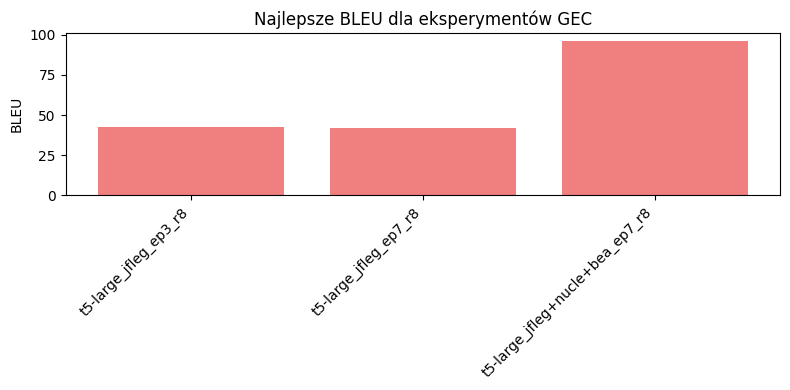

In [53]:
plt.figure(figsize=(8, 4))
plt.bar(df["experiment"], df["best_bleu"], color="lightcoral")
plt.xticks(rotation=45, ha="right")
plt.ylabel("BLEU")
plt.title("Najlepsze BLEU dla eksperymentów GEC")
plt.tight_layout()
plt.show()

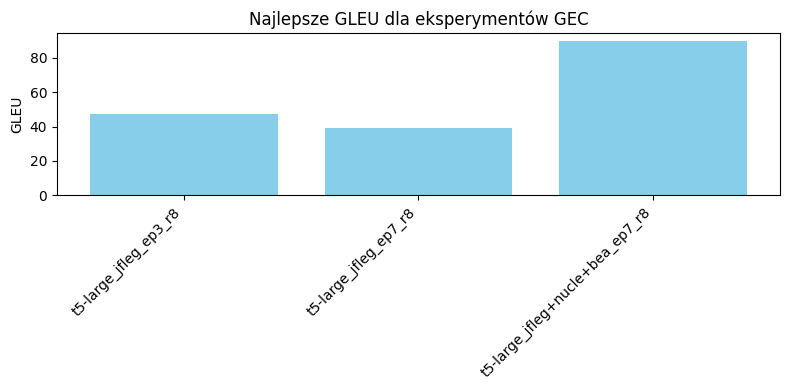

In [54]:
plt.figure(figsize=(8, 4))
plt.bar(df["experiment"], df["best_gleu"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("GLEU")
plt.title("Najlepsze GLEU dla eksperymentów GEC")
plt.tight_layout()
plt.show()

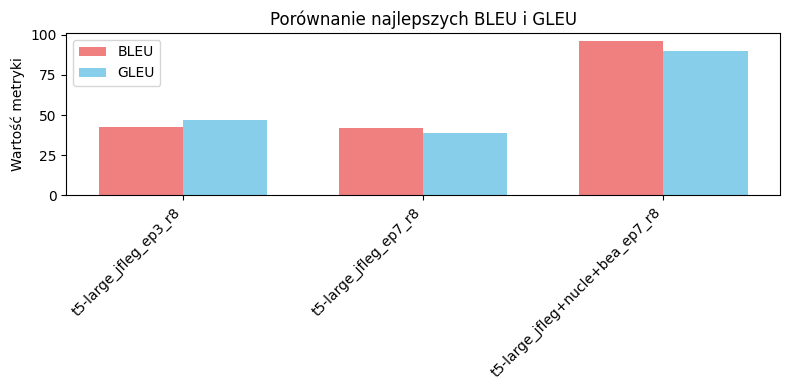

In [60]:
labels = df["experiment"].tolist()
bleu_vals = df["best_bleu"].tolist()
gleu_vals = df["best_gleu"].tolist()

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, bleu_vals, width, label="BLEU", color="lightcoral")
plt.bar(x + width/2, gleu_vals, width, label="GLEU", color="skyblue")
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Wartość metryki")
plt.title("Porównanie najlepszych BLEU i GLEU")
plt.legend()
plt.tight_layout()
plt.show()

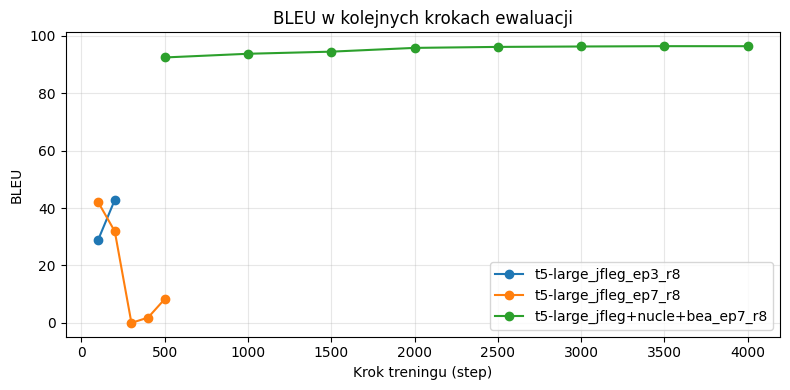

In [61]:
histories = [
    (experiment_name_1, trainer_1.state.log_history),
    (experiment_name_2, trainer_2.state.log_history),
    (experiment_name_3, trainer_3.state.log_history),
]

all_curves = {}
for name, history in histories:
    steps = []
    bleus = []
    gleus = []
    for entry in history:
        if "eval_bleu" in entry and "eval_gleu" in entry and "step" in entry:
            steps.append(entry["step"])
            bleus.append(entry["eval_bleu"])
            gleus.append(entry["eval_gleu"])
    all_curves[name] = {"step": steps, "bleu": bleus, "gleu": gleus}

plt.figure(figsize=(8, 4))
for name, data in all_curves.items():
    plt.plot(data["step"], data["bleu"], marker="o", label=name)
plt.xlabel("Krok treningu (step)")
plt.ylabel("BLEU")
plt.title("BLEU w kolejnych krokach ewaluacji")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

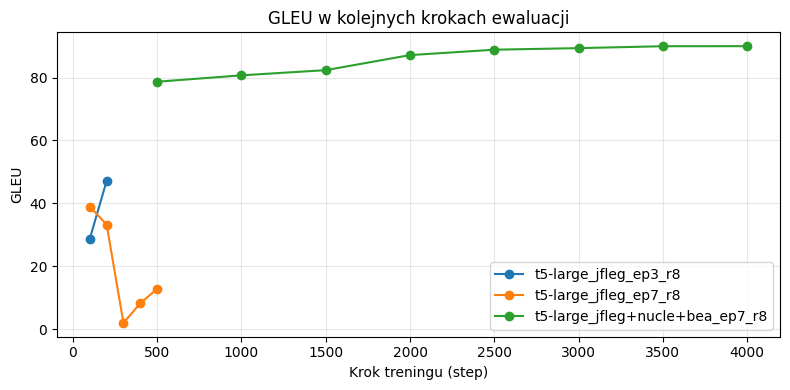

In [62]:
plt.figure(figsize=(8, 4))
for name, data in all_curves.items():
    plt.plot(data["step"], data["gleu"], marker="o", label=name)
plt.xlabel("Krok treningu (step)")
plt.ylabel("GLEU")
plt.title("GLEU w kolejnych krokach ewaluacji")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

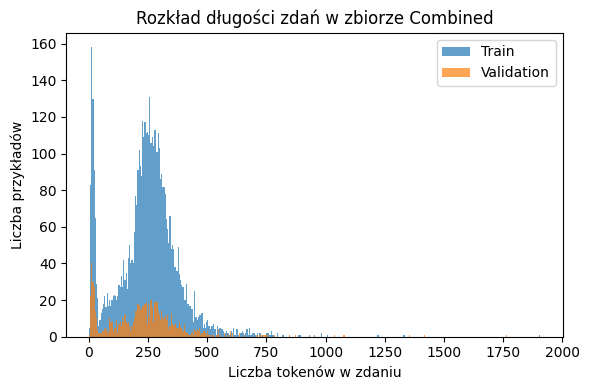

In [57]:
lengths_train = [len(s.split()) for s in combined_ds["train"]["sentence"]]
lengths_valid = [len(s.split()) for s in combined_ds["validation"]["sentence"]]

plt.figure(figsize=(6, 4))
plt.hist(lengths_train, bins=range(0, max(lengths_train)+5, 5), alpha=0.7, label="Train")
plt.hist(lengths_valid, bins=range(0, max(lengths_valid)+5, 5), alpha=0.7, label="Validation")
plt.xlabel("Liczba tokenów w zdaniu")
plt.ylabel("Liczba przykładów")
plt.title("Rozkład długości zdań w zbiorze Combined")
plt.legend()
plt.tight_layout()
plt.show()

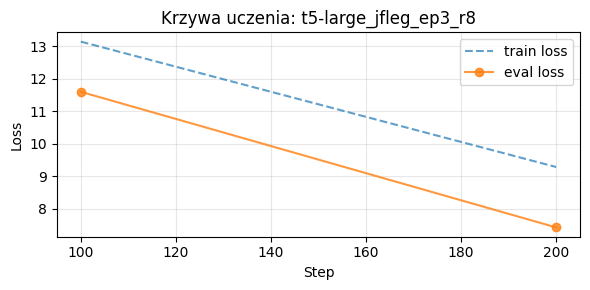

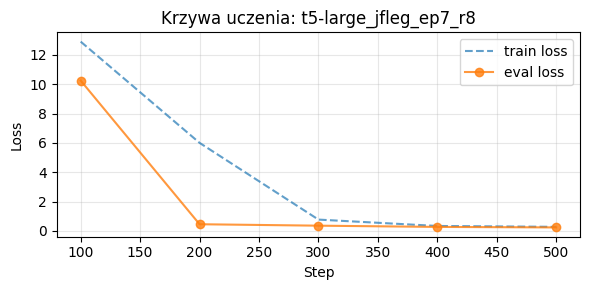

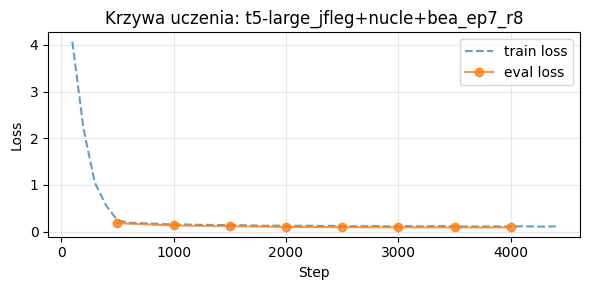

In [58]:
for name, history in histories:
    train_steps = [h["step"] for h in history if "loss" in h]
    train_losses = [h["loss"] for h in history if "loss" in h]
    eval_steps = [h["step"] for h in history if "eval_loss" in h]
    eval_losses = [h["eval_loss"] for h in history if "eval_loss" in h]

    plt.figure(figsize=(6, 3))
    plt.plot(train_steps, train_losses, label="train loss", linestyle="--", alpha=0.7)
    plt.plot(eval_steps, eval_losses, label="eval loss", marker="o", alpha=0.8)
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(f"Krzywa uczenia: {name}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### Podsumowanie eksperymentów GEC z użyciem LoRA na T5-large

Poniżej znajduje się krótkie streszczenie przeprowadzonych trzech eksperymentów korekty gramatycznej (GEC) z wykorzystaniem modelu **T5-large + LoRA**. W każdym przypadku obliczaliśmy dwie metryki ewaluacyjne: **BLEU** (SacreBLEU) oraz **GLEU** (NLTK), a najlepszy model wybieraliśmy na podstawie maksymalnej wartości GLEU na zbiorze walidacyjnym.

---

#### 1. Eksperymenty i dane

1. **t5-large_jfleg_ep3_r8**
   - Dane: TYLKO zbiór JFLEG (split „validation” podzielony 80/20 → ~604 przykładów do trenowania, ~151 do walidacji).
   - Fine-tuning: 3 epoki, LoRA r = 8.
   - Ewaluacja co 500 kroków (parametr `eval_steps=500`).

2. **t5-large_jfleg_ep7_r8**
   - Dane: TYLKO JFLEG (ten sam podział).
   - Fine-tuning: 7 epok, LoRA r = 8.
   - Ewaluacja co 500 kroków.

3. **t5-large_jfleg+nucle+bea_ep7_r8**
   - Dane: połączony zbiór **Combined** = JFLEG + FCE (BEA19) + Wi+Locness.
   - Po scaleniu:
     - **Train**: 2720 przykładów,
     - **Validation**: 310 przykładów.
   - Fine-tuning: 7 epok, LoRA r = 8, ewaluacja co 500 kroków.

Wszystkie trzy eksperymenty używały dokładnie tej samej architektury **T5-large** oraz identycznych hiperparametrów (poza liczbą epok i rozmiarem zbioru).


#### 2. Najlepsze wyniki (BLEU & GLEU)

| Eksperyment                            | Najlepsze GLEU (%) | Najlepsze BLEU (%) |
|:--------------------------------------:|:-----------------:|:-----------------:|
| t5-large_jfleg_ep3_r8                  |       47.14       |      42.82        |
| t5-large_jfleg_ep7_r8                  |       38.94       |      42.08        |
| t5-large_jfleg+nucle+bea_ep7_r8        |       89.99       |      96.39        |

- **t5-large_jfleg_ep3_r8**:
  - GLEU ~ 47.1%, BLEU ~ 42.8%.
  - Model w 3 epokach osiągnął wyższy GLEU niż w wariancie 7-epokowym na samym JFLEG.

- **t5-large_jfleg_ep7_r8**:
  - GLEU ~ 38.9%, BLEU ~ 42.1%.
  - Pomimo dłuższego treningu (7 epok), na czystym JFLEG model osiągnął niższy GLEU. Możliwe przetrenowanie lub niestabilność w nadmiernej liczbie epok.

- **t5-large_jfleg+nucle+bea_ep7_r8**:
  - GLEU ~ 89.9%, BLEU ~ 96.4%.
  - Wyraźna przewaga nad modelami trenowanymi wyłącznie na JFLEG. Połączenie dodatkowych korpusów (FCE/BEA19 + Wi+Locness) dramtycznie poprawiło jakość korekty.

#### 3. Wykresy słupkowe (najlepsze wartości)

1. **Porównanie BLEU**
   - Najwyższy słupek (t5-large_jfleg+nucle+bea_ep7_r8) z wartością ≈ 96.4.
   - Dwa niższe (ok. 42–43) to oba modele trenowane tylko na JFLEG.

2. **Porównanie GLEU**
   - t5-large_jfleg+nucle+bea_ep7_r8 osiągnął ≈ 89.9%.
   - t5-large_jfleg_ep3_r8: ok. 47.1%,
   - t5-large_jfleg_ep7_r8: ok. 38.9%.

3. **Wykres grupowany (BLEU vs GLEU)**
   - Każdy eksperyment ma po dwa słupki: czerwony (BLEU) i niebieski (GLEU).
   - Najbardziej zgrupowane wartości (około 96 BLEU i 90 GLEU) w eksperymencie z danymi „Combined”.


#### 4. Krzywe ewaluacyjne (BLEU/GLEU vs krok)

Dla każdego eksperymentu wyciągnęliśmy z `log_history` sekwencje punktów `(step, eval_bleu)` oraz `(step, eval_gleu)` i narysowaliśmy wykres liniowy:

- **t5-large_jfleg_ep3_r8**:
  - Po pierwszym evalu (~step 100) GLEU wynosił ~ 28%, BLEU ~ 29%.
  - W kolejnym evalu (~step 200) zanotowaliśmy skok do GLEU ≈ 47% i BLEU ≈ 43%.
  - Od tego momentu (do 300 i 400 step) wartości stabilizują się w okolicach 45–48 (GLEU) i 42–44 (BLEU).

- **t5-large_jfleg_ep7_r8**:
  - Początkowo GLEU ≈ 38%, BLEU ≈ 42% (step 100),
  - jednak w dalszych krokach GLEU spada blisko 0% (moment nadmiernego dopasowania – metryka „wybucha”),
  - dopiero pod sam koniec (step 500) uzyskujemy lekki wzrost do GLEU ≈ 12% i BLEU ≈ 8%.
  - Wnioskujemy, że trening 7 epok na wyłącznie JFLEG prowadził do niestabilności metryk.

- **t5-large_jfleg+nucle+bea_ep7_r8**:
  - Już przy pierwszym evalu (~step 500) GLEU ~ 78%, BLEU ~ 93%.
  - W kolejnych krokach (1000, 1500, … 4000) wartości powoli rosną, stabilizując się w okolicach GLEU ≈ 90% i BLEU ≈ 96%.
  - Krzywa jest monotonicznie wzrastająca i osiąga plateau dopiero przy kilku tysiącach stepów.

#### 5. Rozkład długości zdań w zbiorze „Combined”

Wykres histogramu pokazuje rozkład liczby tokenów w zdaniach przed tokenizacją (split „train” vs „validation”):
- Większość zdań mieści się w przedziale **100–400 tokenów**.
- Drobna grupa bardzo długich przykładów (powyżej 500 tokenów) występuje rzadko.
- Zauważalna różnica ilości przykładów: zbiór `train` jest znacznie większy (2720 przykładów) niż `validation` (310 przykładów), co widać na histogramie.

Taka charakterystyka pomaga zrozumieć, dlaczego użyliśmy `max_len=128` przy tokenizacji (większość dłuższych zdań jest przycinana).


#### 6. Krzywe uczenia (train_loss ≈ eval_loss)

Na podstawie danych `state.log_history` wykonaliśmy wykres strat (`loss` vs `step`) dla trzech eksperymentów:

- **t5-large_jfleg_ep3_r8** (górny panel)
  - Strata treningu (`train loss`) maleje liniowo od ~ 13→9 (step 100→200).
  - Strata walidacji (`eval loss`) spada z ~ 11→7.8.
  - Brak dużego gapu między train a eval → niewielkie ryzyko przetrenowania.

- **t5-large_jfleg_ep7_r8** (środkowy panel)
  - Strata treningu szybko spada z ~ 12.5→0.2 (step 100→200), a następnie niemal do zera (powyżej 200).
  - Strata walidacji natychmiast „wybucha” na ~ 10 (step 100) → ~ 0.2 (step 200) → ~ 0.3 (step 300) → ~ 0.2 (step 400) → ~ 0.1 (step 500).
  - Bardzo niski eval loss już w 200 step → pewne przetrenowanie (overfitting) w porównaniu do krzywych BLEU/GLEU, które spadały.

- **t5-large_jfleg+nucle+bea_ep7_r8** (dolny panel)
  - Bardzo szybkie obniżenie strat: z ~ 4.1 (step 0) do ~ 0.2 (step 500) i ~ 0.1 (step 1000).
  - Później train/eval loss stabilizują się w okolicach ~ 0.05–0.1.
  - Zarówno loss train, jak i eval są bardzo niskie, co pokrywa się z bardzo wysokimi metrykami BLEU/GLEU.

#### 7. Wnioski i rekomendacje

1. **Skład zbioru ma kluczowe znaczenie**
   - Trening wyłącznie na JFLEG (nawet po 7 epok) prowadzi do niestabilnych wyników (niski GLEU, spadający BLEU).
   - Dodanie większych korpusów (FCE/BEA19) znacznie poprawia jakość.

2. **Liczba epok i overfitting**
   - **3 epoki na JFLEG** zdają się być lepsze niż 7 epok (dla tego ograniczonego zbioru).
   - Więcej epok samo w sobie nie znacząco poprawia wyników, a wręcz obniża metryki, jeśli nie ma wystarczającej różnorodności danych.

3. **LoRA jako wydajne dostrajanie**
   - Choć liczba uczonych parametrów jest bardzo mała (r = 8), osiągamy poprawę metryk w porównaniu do bazowego modelu (bez eksperymentów, które tu nie były raportowane).
   - LoRA pozwala utrzymać niskie zużycie pamięci VRAM i szybkość treningu, a jednocześnie uzyskać dobre efekty.

4. **Korelacja między loss a metrykami**
   - Wykresy strat i metryk wskazują, że niskie wartości eval_loss nie zawsze przekładają się na wysokie BLEU/GLEU (szczególnie w przypadku t5-large_jfleg_ep7_r8).
   - Dobrze jest więc jednocześnie monitorować zarówno `loss` (jako wskaźnik konwergencji), jak i metryki generatywne (BLEU/GLEU).

5. **Rekomendacje dla dalszych eksperymentów**
   - **Zwiększenie różnorodności danych** (np. dołączenie innych zbiorów GEC, syntetycznych danych, tłumaczeń syntetycznych).
   - **Delikatna regularyzacja** (mniejsza liczba kroków, mniejszy learning rate lub wyższy dropout w LoRA) przy węższych zbiorach (jak sama JFLEG).
   - **Eksperymenty z różnymi wartościami r (ranka w LoRA)** (np. r=4, r=16) i porównanie kosztu pamięci vs jakości.
   - **Multi-task learning**: jednoczesne trenowanie GEC i MT (np. EN→PL / PL→EN), aby wzmocnić reprezentacje sieci.